# First Zonal Harmonic Forecasting via LSTM

In this notebook, I attempt the most basic prediction for the first zonal harmonic of the external field in response to solar activity. The zonal harmonic, corresponding to the associated Legendre polynomial $P_1^0$, is effectively what is measured by the disturbance storm time (Dst) index, except the data that I am trying to reconstruct record only the external field response, while Dst inadvertently includes the fields generated in Earth's subsurface. 

In [3]:
# general
import numpy as np
from sklearn import preprocessing
from scipy.stats import kde
import os
import datetime as dt

# deep learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from aux_keras import *

# file management, io
import pandas as pd
import h5py

# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

## Load Data

Let's load the data without gaps as well as the external coefficients. We'll use the unfiltered coefficients since the filtered coefficients eliminate quite a bit of small scale structure in the time series; in particular many jumps and abrupt changes in the external magnetic field are excessively smoothed and would cause the network to learn unrealistic behaviors.

In [4]:
omni = pd.read_hdf('omni_hourly_1998-2018_nogaps.h5')
coeff = pd.read_hdf('external_coefficients_unfiltered.h5')

The external coefficients report hourly values centered on every half hour, starting at 0:30 on January 1, 1999 (UT). The OMNI series, however, are centered on the hour beginning at 0:00 on January 1, 1998, but contain data averaged throughout the subsequent hour (i.e. hour 0 contains data averaged from 0:00-1:00). While the documentation for the OMNI data do not mention this anywhere, they also report the times with respect to universal time UT, so the time formats are the same between the datasets. 

Thus, both datasets contain data averaged within the same time bins, the bin centers are just denoted differently with the centers at the beginning of the hour for OMNI and at the middle of the hour for the external coefficient series. 

The OMNI data go until 23:00 December 31, 2018, and the corresponding total number of expected data points is computed below and compared to the observed total number of data points.

In [5]:
hrs_yr = 365*24
hrs_yr_lp = 366*24

n_yr = 21
# 2000, 2004, 2008, 2012, 2016
n_lp_yr = 5

hrs_OMNI = hrs_yr*(n_yr-n_lp_yr) + hrs_yr_lp*n_lp_yr

print('Expected number of hours in OMNI data set: %d' % hrs_OMNI)
print('Number of hours in OMNI data set: %d' % len(omni))

Expected number of hours in OMNI data set: 184080
Number of hours in OMNI data set: 184080


As the above code computes, the anticipated number of hours in the OMNI data set is 184080, which is precisely what we get. 

Below, we perform a similar computation for the external coefficients, which span 0:30 January 1, 1999 to 22:30 December 31, 2018. Thus, there should be exactly one year and one hour fewer data points than the OMNI set, since the external coefficients end an hour early in 2018.

In [6]:
hrs_offset = hrs_yr + 1
hrs_ext_coeff = hrs_OMNI - hrs_offset

print('Expected number of hours in external coefficients data set: %d' % hrs_ext_coeff)
print('Number of hours in external coefficients data set: %d' % len(coeff))

Expected number of hours in external coefficients data set: 175319
Number of hours in external coefficients data set: 175319


Thus, the relevant parts of OMNI are neglecting 1998 and the last entry of 2018, which I remove below.

In [7]:
omni = omni[hrs_yr:-1].reset_index(drop=True)
dst = omni['Dst-index, nT']
q10 = coeff['q10']
t = coeff['time'].values
t_year = 2000+t/(365.25) # federico's time axis

Finally, let's include previous values of the $q_1^0$ series in the input data, adding a column then to omni_lr (for now, ideally I wouldn't need to know previous values to make an accurate prediction). Let's also drop the Dst column (I revisit Dst prediction in the [sister notebook](forecasting_Dst_LSTM.ipynb) to this).

Other columns that we'll drop for the moment are:
- Kp-index
- AL-index
- AU-index
- AE-index
- ap-index

since I'm primarily interested in how explicitly physical measurements can be related to predictions of the external field.

Let's also do a simplest case forecasting, using only the following columns (at the moment):
- $B_z$
- SW proton density
- SW plasma speed
- SW plasma temperature

In [8]:
omni = omni.drop(columns=['Dst-index, nT', 'Kp-index', 'AE-index, nT', 'AL-index, nT', 'AU-index, nT', 'ap-index, nT'])

#omni = omni[['BZ, nT (GSM)', 'SW Plasma Temperature, K', 'SW Plasma Speed, km/s', 'SW Proton Density, N/cm^3']]
omni['q10'] = q10.values

nfeatin = len(omni.columns)

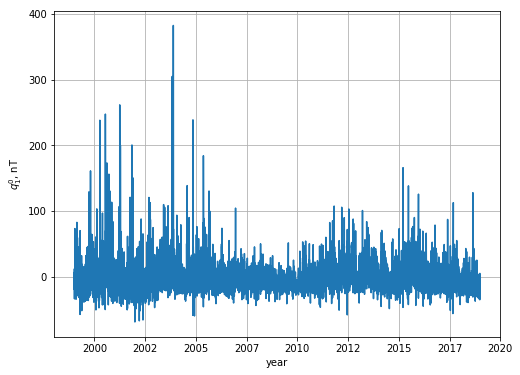

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_year, q10)
ax.set_ylabel('$q_1^0$, nT')
ax.set_xlabel('year')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.grid(True)
plt.show()

## Compare q10 with Dst

Here is a scatter plot of the first zonal coefficient $q_1^0$ compared to Dst, demonstrating their similarities. 

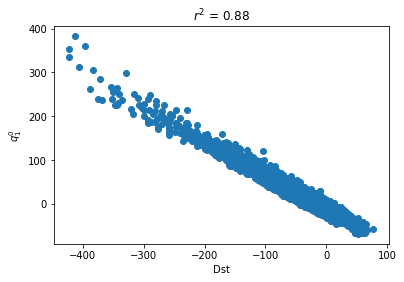

In [270]:
r2 = np.corrcoef(dst,q10)[0,1]**2

plt.scatter(dst,q10)
plt.ylabel('$q_1^0$')
plt.xlabel('Dst')
plt.title('$r^2$ = %1.2f' % r2)
plt.show()

The sign convention differs between datasets, but they both record quite similar values, except during the largest storms when $q_1^0$ takes on larger values than Dst.

## LSTM

Having imported the data, let's design, train, and test the LSTM network for this prediction problem. The LSTM specifics are in the [aux_keras.py](aux_keras.py) module, where two basic architectures are elaborated. One is stateless, in which batches of fixed length are fed to the LSTM during training, while another is stateful, with the entire unbroken training series fed into the LSTM, thereby capturing the entire time history of the training data. 

### Split and Prepare Data

Let's separate the data into training and testing sets. Let's also normalize all of the data according to the training data.

In [11]:
batch_size = 500
lahead = 6
train_percent = 0.8

In [12]:
# split
data_in_train, data_out_train, data_in_test, data_out_test = datasplit(omni.values, \
                        q10.values.reshape(-1,1), batch_size, train_percent, lahead, stateful=True)

# normalize
scaler_input = preprocessing.MinMaxScaler(feature_range=(0,1))
data_in_train = scaler_input.fit_transform(data_in_train)
data_in_test = scaler_input.transform(data_in_test)

scaler_output = preprocessing.MinMaxScaler(feature_range=(0,1))
data_out_train = scaler_output.fit_transform(data_out_train)
data_out_test = scaler_output.transform(data_out_test)

# reshape input data
data_in_train = data_in_train.reshape(-1,1,nfeatin)
data_in_test = data_in_test.reshape(-1,1,nfeatin)

Epoch 0, MSE 1.59e-03
Epoch 1, MSE 1.41e-03
Epoch 2, MSE 1.28e-03
Epoch 3, MSE 1.18e-03
Epoch 4, MSE 1.08e-03
Epoch 5, MSE 9.94e-04
Epoch 6, MSE 9.24e-04
Epoch 7, MSE 8.65e-04
Epoch 8, MSE 8.07e-04
Epoch 9, MSE 7.53e-04
Epoch 10, MSE 7.06e-04
Epoch 11, MSE 6.65e-04
Epoch 12, MSE 6.27e-04
Epoch 13, MSE 5.94e-04
Epoch 14, MSE 5.65e-04
Epoch 15, MSE 5.41e-04
Epoch 16, MSE 5.19e-04
Epoch 17, MSE 5.00e-04
Epoch 18, MSE 4.84e-04
Epoch 19, MSE 4.70e-04
Epoch 20, MSE 4.59e-04
Epoch 21, MSE 4.50e-04
Epoch 22, MSE 4.42e-04
Epoch 23, MSE 4.36e-04
Epoch 24, MSE 4.31e-04
Epoch 25, MSE 4.27e-04
Epoch 26, MSE 4.23e-04
Epoch 27, MSE 4.21e-04
Epoch 28, MSE 4.18e-04
Epoch 29, MSE 4.16e-04
Epoch 30, MSE 4.14e-04
Epoch 31, MSE 4.12e-04
Epoch 32, MSE 4.11e-04
Epoch 33, MSE 4.09e-04
Epoch 34, MSE 4.07e-04
Epoch 35, MSE 4.05e-04
Epoch 36, MSE 4.03e-04
Epoch 37, MSE 4.02e-04
Epoch 38, MSE 4.00e-04
Epoch 39, MSE 3.98e-04
Epoch 40, MSE 3.96e-04
Epoch 41, MSE 3.95e-04
Epoch 42, MSE 3.94e-04
Epoch 43, MSE 3.92e-0

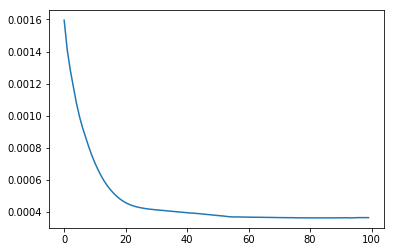

In [13]:
rnn, hist = train_network(data_in_train, data_out_train, batch_size, epochs=100, stateful=True)
plt.plot(hist)

### Test

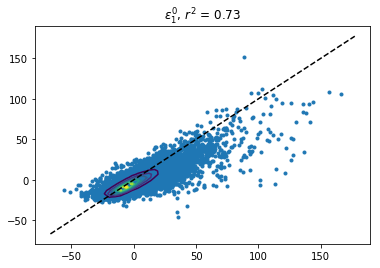

In [14]:
data_out_pred = test_network(data_in_test, data_out_test, rnn, batch_size,'$\epsilon_1^0$', scaler_output)